In [1]:
import pandas as pd
from dataset_nuc import NucleiSegmentationDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from model_HoVer import HalfDualDecUNetPlusPlus
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import albumentations as A
import torch
from torch.utils import data
import numpy as np
from PIL import Image
import os
from he_randaugment import randaugment
import torchvision.transforms as transforms
import cv2
import ast
from scipy.ndimage import label


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/abk9550/.local/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def color_image_to_mask(color_image):
    color_to_class_map = {
    (255, 255, 255): 0,    # Background
    (200, 0, 0): 1,        # nuclei_tumor
    (255, 0, 255): 2,      # TILs (lymphocytes and plasma cells)
    (150, 200, 150): 3,    # Other cells (histiocytes, stromal cells, etc.)
    (0, 255, 0): 3,
    (51, 0, 51): 3,
    (0, 128, 128): 3,
    (204, 204, 51): 3,
    (102, 26, 51): 3,
    (51, 51, 51): 3
    }

    color_array = np.array(color_image)
    unique_colors = np.unique(color_array.reshape(-1, color_array.shape[2]), axis=0)

    # Erstelle eine leere Maske für die Klassenzuordnung
    mask = np.zeros((color_array.shape[0], color_array.shape[1]), dtype=np.uint8)

    for color in unique_colors:
        color_tuple = tuple(color)
        
        # Bestimme die Klasse, entweder durch explizite Zuordnung oder Standardklasse 3
        class_value = color_to_class_map.get(color_tuple, 3)
        
        is_color = np.all(color_array == color_tuple, axis=-1)
        
        if np.any(is_color):  # Nur wenn die Farbe im Bild vorkommt
            mask[is_color] = class_value
    return mask



def compute_hover_maps(maske):
        """
        Berechnet HoVer-Maps (horizontale und vertikale Karten) für eine Instanzsegmentierungsmaske.
    
        Args:
            maske (np.ndarray): 2D-Segmentierungsmaske (Höhe x Breite), bei der jede Klasse als Ganzzahl dargestellt wird.
    
        Returns:
            np.ndarray: Ein Array der Form (Höhe, Breite, 2),
                        wobei der erste Kanal die horizontalen und der zweite Kanal die vertikalen Vektoren enthält.
        """
        # Hintergrund ignorieren und Instanzen labeln
        gelabelte_maske, anzahl_instanz = label(maske > 0)  # Jede Instanz erhält eine eindeutige ID
        #print(f"Anzahl der Instanzen: {anzahl_instanz}")
    
        hoehe, breite = maske.shape
        hover_maps = np.zeros((hoehe, breite, 2), dtype=np.float32)
    
        for instanz_id in range(1, anzahl_instanz + 1):  # ID 0 ist Hintergrund
            # Maske für die aktuelle Instanz
            instanz_maske = (gelabelte_maske == instanz_id).astype(np.uint8)
    
            # Schwerpunkt der Instanz berechnen
            coords = np.argwhere(instanz_maske > 0)
            if len(coords) == 0:
                continue
    
            cx = np.mean(coords[:, 1])  # Durchschnitt der x-Koordinaten
            cy = np.mean(coords[:, 0])  # Durchschnitt der y-Koordinaten
    
            # Maximaldistanz für Normierung berechnen
            max_dist = np.max(np.sqrt((coords[:, 1] - cx)**2 + (coords[:, 0] - cy)**2)) + 1e-8
    
            # Berechne horizontale und vertikale Distanzen für jedes Pixel in der Instanz
            for y, x in coords:
                dx = x - cx
                dy = y - cy
                hover_maps[y, x, 0] = dx / max_dist  # Horizontal
                hover_maps[y, x, 1] = dy / max_dist  # Vertikal
    
        return hover_maps


Processing ROIs:   0%|                                    | 0/4 [00:00<?, ?it/s]

../dataset/nuclei/training_set_metastatic_roi_014.png


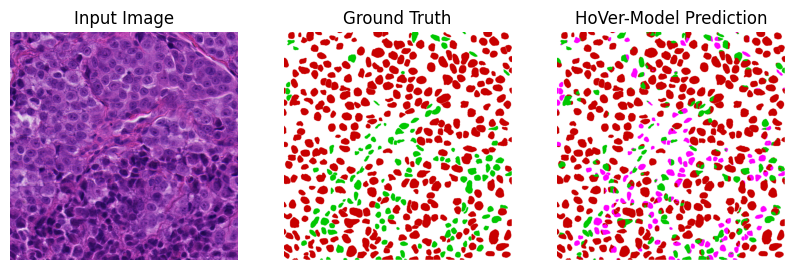

Processing ROIs:  25%|███████                     | 1/4 [00:03<00:09,  3.30s/it]

../dataset/nuclei/training_set_primary_roi_026.png


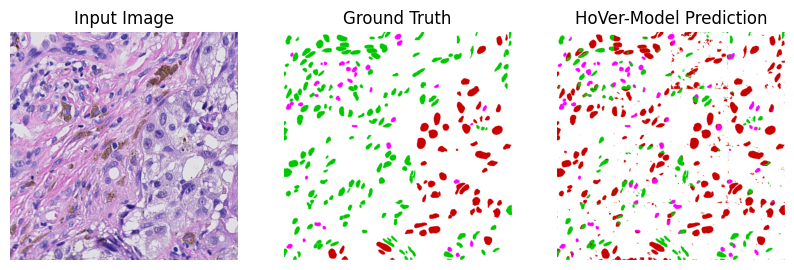

Processing ROIs:  50%|██████████████              | 2/4 [00:05<00:05,  2.91s/it]

../dataset/nuclei/training_set_primary_roi_027.png


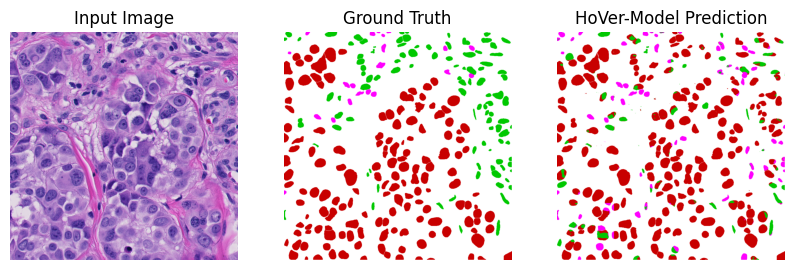

Processing ROIs:  75%|█████████████████████       | 3/4 [00:08<00:02,  2.91s/it]

../dataset/nuclei/training_set_metastatic_roi_081.png


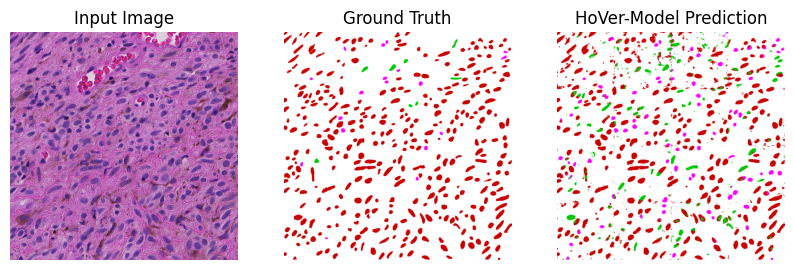

Processing ROIs: 100%|████████████████████████████| 4/4 [00:11<00:00,  2.91s/it]


In [16]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
num_classes = 4
patch_size = 256
class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)       # Other cells
]


def preprocess(image_path, ground_truth):
    """Preprocess image for Extended Input and Dice models."""
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    rgb_image = normalize(image).unsqueeze(0).cuda()  # Add batch dimension

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = torch.tensor(gray_image, dtype=torch.float32) / 255.0
    gray_image = gray_image.unsqueeze(0) 

    hoVerMaps = compute_hover_maps(ground_truth)
    hoVerMaps = torch.tensor(hoVerMaps, dtype=torch.float32).permute(2, 0, 1)  # (2, H, B)
    rgb_image = rgb_image.squeeze(0) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Stelle sicher, dass alle Tensoren auf die GPU verschoben werden
    hoVerMaps = hoVerMaps.to(device)  
    rgb_image = rgb_image.to(device)
    gray_image = gray_image.to(device)
    image = torch.cat((rgb_image, hoVerMaps, gray_image), dim=0)  # (5, H, B)
    return  image.unsqueeze(0)

num_classes = 4



def apply_color_mapping(mask):
    """Map class values in the mask to RGB colors."""
    
    class_colors = [
    (255, 255, 255),  # Background
    (200, 0, 0),      # nuclei_tumor
    (255, 0, 255),    # nuclei_lymphocyte
    (0, 200, 0)   # Other cells
    ]
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for k, color in enumerate(class_colors):
        mask_rgb[mask == k] = color
    return mask_rgb

def process_patches(model, image, patch_size, num_classes):
    """Perform patch-wise inference on the image."""
    _, _, h, w = image.shape
    full_pred = np.zeros((h, w, num_classes), dtype=np.float32)

    # Loop through the image in patches
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[:, :, y:y + patch_size, x:x + patch_size]

            # Pad patch if it exceeds boundaries
            pad_h = patch_size - patch.shape[2] if patch.shape[2] < patch_size else 0
            pad_w = patch_size - patch.shape[3] if patch.shape[3] < patch_size else 0
            if pad_h > 0 or pad_w > 0:
                patch = nn.functional.pad(patch, (0, pad_w, 0, pad_h), mode='constant', value=0)

            with torch.no_grad():
                output = model(patch)
            pred_patch = output.squeeze(0).cpu().numpy()  # Shape: (num_classes, H, W)

            # Transpose pred_patch to (H, W, num_classes)
            pred_patch = np.transpose(pred_patch, (1, 2, 0))

            # Add prediction to full image
            full_pred[y:y + patch_size, x:x + patch_size, :] += pred_patch[:patch.shape[2], :patch.shape[3], :]

    # Convert logits to class predictions
    full_pred = np.argmax(full_pred, axis=-1)
    return full_pred

def visualize_predictions(models, rois, base_path, g_path):
    """Visualize predictions from multiple models."""
    
    for roi in tqdm(rois, desc="Processing ROIs"):
        image_path = os.path.join(base_path, roi + ".tif")
        ground_truth_path = os.path.join(str(g_path), str(roi) + ".png")
        print(ground_truth_path)

        ground_truth = Image.open(ground_truth_path).convert('RGB')  # Load as RGB
        ground_truth = color_image_to_mask(ground_truth)  # Convert to class mask   
        ground_truth_rgb = apply_color_mapping(ground_truth)
        
        # Process predictions for each model
        predictions = {}
        for model_name, model in models.items():

            image = preprocess(image_path, ground_truth)
            predictions[model_name] = process_patches(model, image, patch_size, num_classes)

        # Map masks to RGB for visualization
      
        pred_rgb = {k: apply_color_mapping(v) for k, v in predictions.items()}

        # Plot input image, ground truth, and predictions
        input_image = np.array(Image.open(image_path))  # Reload for display
        fig, axes = plt.subplots(1, len(models) + 2, figsize=(10, 5))
        axes[0].imshow(input_image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(ground_truth_rgb)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        for idx, (model_name, pred) in enumerate(pred_rgb.items(), start=2):
            axes[idx].imshow(pred)
            axes[idx].set_title(f"{model_name} Prediction")
            axes[idx].axis("off")

        plt.show()

# Load models
models = {
    "HoVer-Model": nn.Sequential(HalfDualDecUNetPlusPlus(num_classes=4,in_channel=6), nn.Sigmoid()).cuda(),
}

# Load weights for each model
models["HoVer-Model"][0].load_state_dict(torch.load(r"../Hover/logs/HoVerUnet2/best_f1.pt"))

# ROIs and paths
rois = [
    "training_set_metastatic_roi_014",
    "training_set_primary_roi_026",
    "training_set_primary_roi_027",
    "training_set_metastatic_roi_081"
]
base_path = r"../dataset/01_training_dataset_tif_ROIs"
ground_truth_path = r"../dataset/nuclei"

# Visualize predictions
visualize_predictions(models, rois, base_path, ground_truth_path)
